In [1]:
import os
cwd = os.getcwd()
cwd

'/home/vtm/Transformer-for-EEG'

In [2]:
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.executable

'/home/vtm/anaconda3/envs/transformer/bin/python'

## Model Architecture

### Options for Model

In [4]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.generator(self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [5]:
class Generator(nn.Module):
    "Define standard linear"
    def __init__(self, d_model,output_d):
        super(Generator, self).__init__()
        self.proj1 = nn.Linear(d_model, output_d)

    def forward(self, x):
        return self.proj1(x)

## Encoder and Decoder Stacks   

### Encoder

In [99]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [100]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [101]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [102]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

In [103]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [104]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

### Attention      
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [105]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.   

In [106]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Positionwise Forward
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$  

In [107]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embedding

In [108]:
class Embeddings(nn.Module):
    def __init__(self, d_model, input_d):
        super(Embeddings, self).__init__()
        self.proj = nn.Linear(input_d, d_model)

    def forward(self, x):
        return self.proj(x)

## Positional Encoding           
In this work, we use sine and cosine functions of different frequencies:       

$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$   

In [109]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1) # [max_len,1] 
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

# Full Model

In [110]:
def make_model(src_d,tgt_d,N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_d),c(position)),
        nn.Sequential(Embeddings(d_model, tgt_d),c(position)),
        Generator(d_model,tgt_d))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

#  Optimizor
$$
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                     

In [111]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Loss Computation

In [112]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y,norm): 
        #x = self.generator(x)
        loss = self.criterion(x.contiguous(), y.contiguous())
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() 

## Data Batch + Masking

In [113]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [114]:
# Padding Mask for src, Sequence Mask for tgt
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
# uncomment the following part if using CUDA
#         self.src = src.cuda()
#         self.src_mask = Variable(torch.ones(src.size(0), 1, src.size(1)) ).cuda()
#         if trg is not None:
#             self.trg = trg[:, :-1,:].cuda()
#             self.trg_y = trg[:, 1:,:].cuda()
#             self.trg_mask = \
#                 self.make_std_mask(self.trg, pad).cuda()
#             self.ntokens = self.trg_y.size(1)
# uncomment the following part if using CPU
        self.src = src
        self.src_mask = Variable(torch.ones(src.size(0), 1, src.size(1)) )
        if trg is not None:
            self.trg = trg[:, :-1,:]
            self.trg_y = trg[:, 1:,:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = self.trg_y.size(1)    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
 
        tgt_mask = Variable(torch.ones(tgt.size(0), 1, tgt.size(1),dtype = torch.long))
        tgt_mask = tgt_mask.type_as(tgt_mask.data) & Variable(subsequent_mask(tgt.size(1)).type_as(tgt_mask.data))
        return tgt_mask

## Generating Linear Dynamic System Data

The model is formulated as:

$x_0 \sim \mathcal{N}(\mu_{\text{init}},\sigma_{\text{init}})$

$x_{t+1} \sim \mathcal{N}(\boldsymbol{A} x_{t}+\boldsymbol{B} u_{t},\sigma_{\text{state}})$

$y_{t}  \sim \mathcal{N}(\boldsymbol{C} x_{t}+\boldsymbol{D} u_{t},\sigma_{\text{obs}})$

In [115]:
# PyLDS is a Python library for gaussian linear dynamical systems (GLDS) PyLDS also implements
# various methods to perform bayesian inference on GLDSs.DefaultLDS (see the cell below) implements a 
# general purpose linear dynamical system with gaussian noise
from pylds.models import DefaultLDS
# Seeding the random number generators for reproducible results
npr.seed(0)
torch.manual_seed(1)
torch.cuda.manual_seed_all(2)

In [116]:
TIMESTEPS = 300 # number of steps in time
INSTS = 1000 # batch-size or the number of instances
DOBS = 10 # number of observable variables
DLAT = 2 # number of hidden variabkes (latent states)

def simple_lds(d_observed=DOBS,d_latent=DLAT,d_input=-1,timesteps=TIMESTEPS,insts=INSTS):
    ## d_observed : dimensionality of observed data
    ## d_latent : dimensionality of latent states
    ## d_input : dimensionality of input data. For d_input=-1 a model with no input is generated
    ## timesteps: number of simulated timesteps
    ## insts: number of instances

    ## instantiating an lds with a random rotational dynamics matrix
    
    if d_input == -1 :
        lds_model = DefaultLDS(d_observed,d_latent,0)
        input_data = None
    else:
        lds_model = DefaultLDS(d_observed,d_latent,d_input)
        input_data = npr.randn(insts,timesteps,d_input)
    
    # initializing the output matrices:
    training_set = np.zeros((insts, timesteps, d_observed))
    latent_states= np.zeros((insts, timesteps, d_latent))
    
    # running the model and generating data
    for i in range(insts):
        training_set[i,:,:], latent_states[i,:,:] = lds_model.generate(timesteps, inputs=input_data)
    return training_set, latent_states, lds_model

In [117]:
# Instantiating a Model and Generating Data
ts,ls,mdl = simple_lds()

In [118]:
# mu_init , sigma_init
print("mu_init:\n",mdl.mu_init,"\nsigma_init:\n",mdl.sigma_init)
# A , B, sigma_state
print("A:\n",mdl.A,"\nB (since we don't have any input):\n",mdl.B,"\nsigma_state:\n",mdl.sigma_states)
# C , D, sigma_obs
print("C:\n",mdl.C,"\nD (since we don't have any input):\n",mdl.D,"\nsigma_obs:\n",mdl.sigma_obs)

mu_init:
 [0. 0.] 
sigma_init:
 [[1. 0.]
 [0. 1.]]
A:
 [[ 0.61017762  0.77960456]
 [-0.77960456  0.61017762]] 
B (since we don't have any input):
 [] 
sigma_state:
 [[0.1 0. ]
 [0.  0.1]]
C:
 [[-0.87736332 -1.6210875 ]
 [-0.581673   -0.53783395]
 [-1.55602368 -0.05446484]
 [-1.81127879 -0.63117522]
 [-0.92815918  1.49072192]
 [ 0.19549934 -0.47160433]
 [ 1.81235465 -2.29413748]
 [ 0.65120935 -1.13049645]
 [-0.77734666  1.11593845]
 [ 1.33945302 -1.76743365]] 
D (since we don't have any input):
 [] 
sigma_obs:
 [[0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]]


In [119]:
ts.shape,ls.shape

((1000, 300, 10), (1000, 300, 2))

In [120]:
ts_train, ls_train = ts[:800],ls[:800]
ts_test, ls_test = ts[800:],ls[800:]
input_d, output_d = ts_train.shape[2], ls_train.shape[2]
timesteps = ts_train.shape[1]
print('input_d:',input_d,'output_d:',output_d,'timesteps:',timesteps)
ts_train.shape,ls_train.shape,ts_test.shape,ls_test.shape

input_d: 10 output_d: 2 timesteps: 300


((800, 300, 10), (800, 300, 2), (200, 300, 10), (200, 300, 2))

# Training for Dynamic Linear System Data

In [121]:
# Model options
opt = {}
opt['Transformer-layers'] = 4
opt['Model-dimensions'] = 256
opt['feedford-size'] = 512
opt['headers'] = 8
opt['dropout'] = 0.1
opt['src_d'] = 10
opt['tgt_d'] = 2

In [122]:
def data_gen(nbatches,minibatch,src,tgt,start_symbol = 1):
    "combine src and tgt as Batch Class"
    for i in range(nbatches):
        data1 = torch.from_numpy(src[i*minibatch:(i+1)*minibatch]) 
        data1[:,0,:] = start_symbol
        src_ = Variable(data1.float(), requires_grad=False)
        data2 = torch.from_numpy(tgt[i*minibatch:(i+1)*minibatch] )
        data2[:,0, :] = start_symbol
        tgt_ = Variable(data2.float(), requires_grad=False)
        yield Batch(src_, tgt_, 0)

In [123]:
def run_epoch(data_iter, model,loss_compute):
    "run the model and record loss"
    total_loss = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y,batch.ntokens)
        total_loss += loss
    return total_loss / (i+1)     

In [124]:
import torch.optim as optim
criterion = nn.MSELoss()
model = make_model(opt['src_d'],opt['tgt_d'],opt['Transformer-layers'],opt['Model-dimensions'],opt['feedford-size'],opt['headers'],opt['dropout'])
# uncomment if using CUDA
# model.cuda()
model_opt = NoamOpt(model_size=opt['Model-dimensions'], factor=1, warmup=400,
        optimizer = torch.optim.Adam(model.parameters(), lr=0.015, betas=(0.9, 0.98), eps=1e-9))

total_epoch = 2000
train_losses=np.zeros(total_epoch)
#test_losses=np.zeros(total_epoch)
for epoch in range(total_epoch):
    model.train()
    loss1 = run_epoch(data_gen(16,50,ts_train,ls_train), model, SimpleLossCompute(model.generator, criterion, model_opt))
    train_losses[epoch]=loss1
    
    if (epoch+1)%100 == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model_opt.optimizer.state_dict(),
                    'loss': loss1,
                    }, 'model_toydata_checkpoint/'+str(epoch)+'.pth')  
        
        torch.save(model, 'model_toydata_save/model_toydata%d.pth'%(epoch))
        model.eval()
        loss2 = run_epoch(data_gen(5,40,ts_test,ls_test), model, SimpleLossCompute(model.generator, criterion, None))
        print('Epoch[{}/{}],test_loss: {:.6f}'
                  .format(epoch+1, total_epoch,loss2))    
    print('Epoch[{}/{}], train_loss: {:.6f}'
              .format(epoch+1, total_epoch, loss1))

Epoch[1/2000], train_loss: 3.514703


KeyboardInterrupt: 

In [ ]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(train_losses, label='Train-loss')
#line2, = plt.plot(test_losses, label='Test-loss')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

# Prediction for Dynamic Linear System Data

In [95]:
model = torch.load('model_toydata_save/model_toydata399.pth')

In [96]:
def output_prediction(model,ts_test,ls_test, max_len, start_symbol,output_d):
    data1 = torch.from_numpy(ts_test).unsqueeze(0).float()
    data1[:,0, :] = 1
    data2 = torch.from_numpy(ls_test).unsqueeze(0).float()
    data2[:,0, :] = 1
    src = Variable(data1, requires_grad=False)
    tgt = Variable(data2, requires_grad=False)
    test_batch = Batch(src, tgt, 0)
    src = test_batch.src
    src_mask = test_batch.src_mask
    
    model.eval()
    memory = model.encode(src.float(), src_mask)
    ys = torch.ones(1, 1, output_d).fill_(start_symbol)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, Variable(ys), Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        out = model.generator(out)
        ys = torch.cat([ys, out[:,[-1],:]], dim=1)
    outs = [out.cpu() for out in ys]
    return torch.stack(outs,0).detach().numpy(), data2


In [97]:
def viz(model,ts,ls,max_len=timesteps,start_symbol=1):
    test_out, true_out = output_prediction(model, ts,ls, max_len=timesteps, start_symbol=1,output_d=output_d)
    
    fig = plt.figure(figsize=(10, 5), dpi=100)

    ax1 = fig.add_subplot(211)
    ax1.plot(test_out.squeeze(0))
    

    ax2 = fig.add_subplot(212)
    ax2.plot(true_out.numpy().squeeze(0))

    fig = plt.gcf()

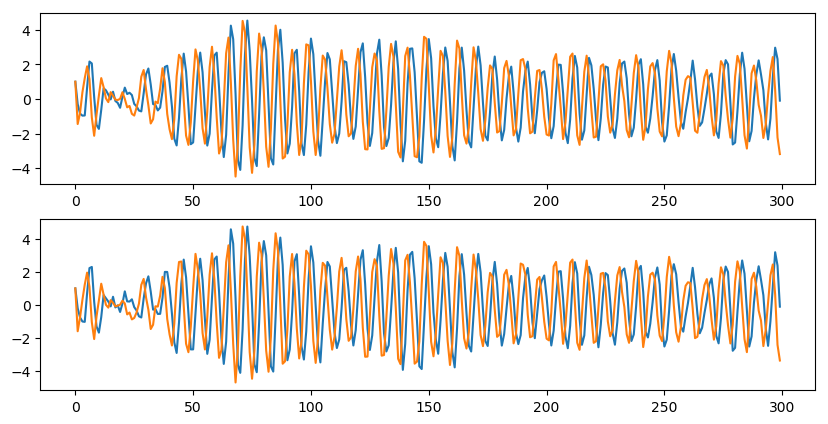

In [98]:
viz(model, ts_test[1],ls_test[1])

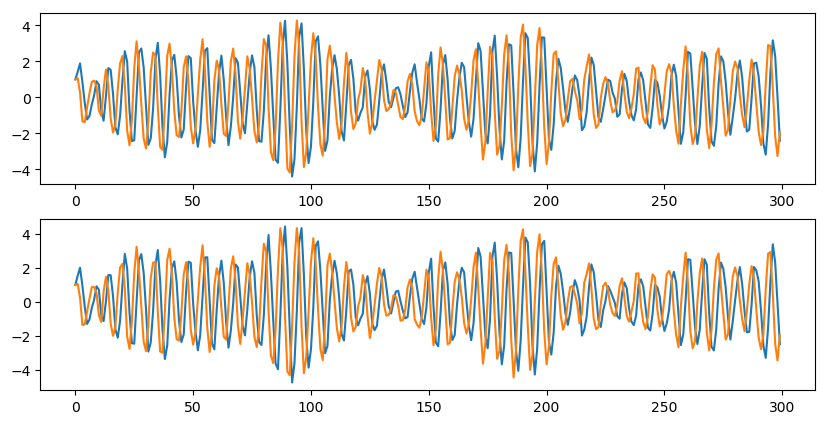

In [40]:
viz(model, ts_test[20],ls_test[20])

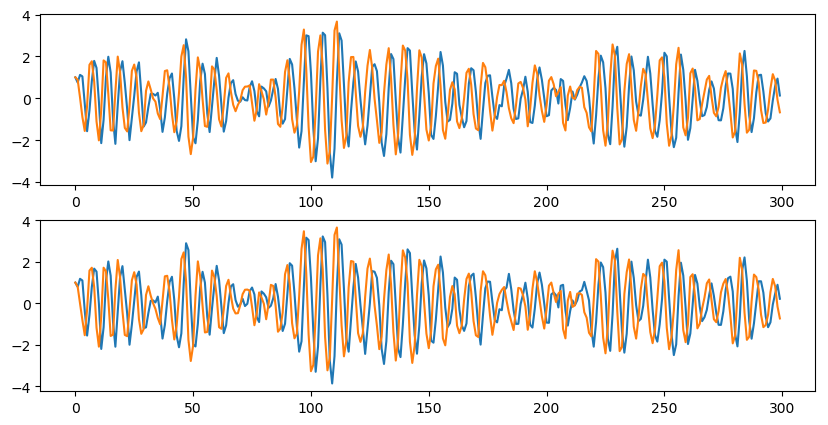

In [41]:
viz(model, ts_test[150],ls_test[150])

# Generating EEG Data

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy.signal import detrend, filtfilt, butter, iirnotch, welch
from torch.utils.data import DataLoader
import json
from tqdm import trange

In [43]:
seq_len = 20
eeg_channels = 32
eeg_size = seq_len*eeg_channels*50
embedding_channels = 256
embedding_size = seq_len*embedding_channels*3

In [44]:
# Dataset class
class EEGDataset(Dataset):
    
    # Constructor
    def __init__(self, npz_file, experiment = 'rpoint', params = None, split='train'):        
        
        # Determine type of task
        if experiment in ['rwalk', 'rpoint']:
            self.supervised = True
        elif experiment in ['imagine', 'music', 'speech', 'video']:
            self.supervised = False
        
        # Load data
        data = np.load(npz_file)        
        
        self.eeg = data['EEG']
        if self.supervised == True:
            self.embedding = data['E']
        self.channels = data['channels']  
        self.split = split
        
        # Setting parameters
        if params == None:
            params = {}
            params['num_atoms'] = 1
            params['standardise'] = True
            params['pipeline'] = None
            params['detrend_window'] = 10
            params['sampling_freq'] = 500
            params['line_freq'] = 60
            params['Q_notch'] = 30
            params['low_cutoff_freq'] = 2.
            params['high_cutoff_freq'] = 45.
            params['flatten'] = False
            params['split_ratio'] = [0.7,0,0.3] # train, validation, test
        self.params = params   
        
        # Split dataset and assign to variables
        self.split_dataset()       
        
        # Change to specified length and reshape
        if self.eeg.shape[0]%self.params['num_atoms'] != 0:
            end = (self.eeg.shape[0]//self.params['num_atoms'])*self.params['num_atoms']
            self.eeg = self.eeg[:end]
            if self.supervised == True:                
                self.embedding = self.embedding[:end]
            
        new_atom_size = (self.eeg.shape[0]//self.params['num_atoms'])
        a, b, c = self.eeg.shape
        self.eeg = self.eeg.reshape(new_atom_size, b*self.params['num_atoms'], c)
        if self.supervised == True:          
            a, b, c = self.embedding.shape
            self.embedding = self.embedding.reshape(new_atom_size, b*self.params['num_atoms'], c)         

        # Compute size
        self.size = len(self.eeg)
        self.num_channels = self.eeg.shape[2]
        
        # Process parameters and assign to variables
        self.process()      

    def split_dataset(self):
        # Determine split indices
        lims = np.dot(self.params['split_ratio'], self.eeg.shape[0])
        lim_ints = [int(lim) for lim in lims]
        lim_ints = np.cumsum(lim_ints)
                
        eeg_sets = {'train': self.eeg[0:lim_ints[0]],
                    'val': self.eeg[lim_ints[0]:lim_ints[1]],
                    'test': self.eeg[lim_ints[1]:]
                   }
        
        if self.supervised == True:          
            emb_sets = {'train': self.embedding[0:lim_ints[0]],
                        'val': self.embedding[lim_ints[0]:lim_ints[1]],
                        'test': self.embedding[lim_ints[1]:]
                       } 
        
        # Assign particular split
        self.eeg = eeg_sets[self.split]
        if self.supervised == True:          
            self.embedding = emb_sets[self.split]
        return
        
        
    def process(self):
        if self.params['standardise'] == True:
            a,b,c = self.eeg.shape
            eeg_n = self.eeg.reshape(a*b,c)
            mean, std = np.mean(eeg_n, axis = 0), np.std(eeg_n, axis = 0)
            eeg_n = (eeg_n-mean)/std
            eeg_n = eeg_n.reshape(a,b,c)
            self.eeg = eeg_n          
        return                        
        
    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        
        eeg_i = self.eeg[i]
        if self.supervised == True:          
            emb_i = self.embedding[i]        
        
        if self.params['pipeline'] != None:            
            for step in self.params['pipeline']:

                if step == 'rereference':
                    ref = np.mean(eeg_i, axis=1)
                    for ch in range(eeg_i.shape[1]):
                        eeg_i[:, ch] = eeg_i[:, ch] - ref                                       
                    
                elif step == 'detrend':
                    eeg_i = detrend(eeg_i, axis=0, 
                                    bp=np.arange(0, eeg_i.shape[0], 
                                                 self.params['detrend_window'] * self.params['sampling_freq'], 
                                                 dtype="int32"))                 
                    
                elif step == 'remove_line_freq':                   
                    b, a = iirnotch(self.params['line_freq'], 
                                    self.params['Q_notch'], 
                                    self.params['sampling_freq'])  # scipy 1.2.0
                    for ch in range(self.num_channels):
                        filtered = filtfilt(b, a, eeg_i[:, ch])
                        eeg_i[:, ch] = filtered
                    
                elif step == 'bandpassfilter': 
                    nyq = 0.5 * self.params['sampling_freq']
                    normal_cutoff1 = self.params['low_cutoff_freq'] / nyq
                    normal_cutoff2 = self.params['high_cutoff_freq'] / nyq
                    [b, a] = butter(5, [normal_cutoff1, normal_cutoff2], btype='bandpass', analog=False)

                    for ch in range(self.num_channels):
                        filtered = filtfilt(b, a, eeg_i[:, ch])
                        eeg_i[:, ch] = filtered 
                        
        if self.params['flatten'] == True:
            eeg_i = eeg_i.flatten()
            if self.supervised == True:              
                emb_i = emb_i.flatten()
                
        
        if self.supervised == True:  
            to_return = (torch.from_numpy(eeg_i).float(), torch.from_numpy(emb_i).float())
        else:
            to_return = torch.from_numpy(eeg_i).float()
        return to_return

In [45]:
# Usage
params = {}
params['num_atoms'] = seq_len
params['standardise'] = True
params['pipeline'] = ['rereference', 'detrend', 'bandpassfilter']
params['detrend_window'] = 50
params['sampling_freq'] = 500
params['Q_notch'] = 30
params['low_cutoff_freq'] = 0.1
params['high_cutoff_freq'] = 249.
params['flatten'] = False
params['split_ratio'] = [0.9,0,0.1]

batch_size = 10
eeg_dataset_train = EEGDataset('rwalk.npz','rwalk', params, split='train')
dataloader_train = DataLoader(eeg_dataset_train, batch_size=batch_size, shuffle=True)

eeg_dataset_test = EEGDataset('rwalk.npz','rwalk', params, split='test')
dataloader_test = DataLoader(eeg_dataset_test, batch_size=batch_size, shuffle=True)

# Training for EEG DATA

In [133]:
# Model options
opt = {}
opt['Transformer-layers'] = 3
opt['Model-dimensions'] = 256
opt['feedford-size'] = 512
opt['headers'] = 8
opt['dropout'] = 0.1
opt['src_d'] = 32
opt['tgt_d'] = 256

In [47]:
def eeg_data_gen(dataloader,start_symbol = 1):
    "combine src and tgt as Batch Class"
    for idx, (data_x,data_y) in enumerate(dataloader):
        data_x[:,0,:] = start_symbol
        src_ = Variable(data_x.float(), requires_grad=False)
        data_y[:,0, :] = start_symbol
        tgt_ = Variable(data_y.float(), requires_grad=False)
        yield Batch(src_, tgt_, 0)

In [48]:
def run_epoch(data_iter, model,loss_compute):
    "run the model and record loss"
    total_loss = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y,batch.ntokens)
        total_loss += loss
    return total_loss / (i+1)     

In [49]:
criterion = nn.MSELoss()
model = make_model(opt['src_d'],opt['tgt_d'],opt['Transformer-layers'],opt['Model-dimensions'],opt['feedford-size'],opt['headers'],opt['dropout'])
# uncomment if using CUDA!
# model.to('cuda')
model_opt = NoamOpt(model_size=opt['Model-dimensions'], factor=1, warmup=400,
        optimizer = torch.optim.Adam(model.parameters(), lr=0.015, betas=(0.9, 0.98), eps=1e-9))

total_epoch = 2000
train_losses=np.zeros(total_epoch)
#test_losses=np.zeros(total_epoch)
for epoch in range(total_epoch):     
    model.train()
    loss1 = run_epoch(eeg_data_gen(dataloader_train), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    train_losses[epoch]=loss1   
    
    if (epoch+1)%10 == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model_opt.optimizer.state_dict(),
                    'loss': loss1,
                    }, 'model_checkpoint/'+str(epoch)+'.pth')            

        
        torch.save(model, 'model_save/model%d.pth'%(epoch))
        model.eval()
        loss2 = run_epoch(eeg_data_gen(dataloader_test), model, 
              SimpleLossCompute(model.generator, criterion, None))
        print('Epoch[{}/{}],test_loss: {:.6f}'
                  .format(epoch+1, total_epoch,loss2))
    
    print('Epoch[{}/{}], train_loss: {:.6f}'
              .format(epoch+1, total_epoch, loss1))

KeyboardInterrupt: 

## Prediction for EEG data

In [129]:
model = torch.load('model_save/model679.pth')
model.cpu()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): Linear(in_features=256, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout): Dropout(p=0.1)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1)
        

In [130]:
def output_prediction(model,ts_test,ls_test, max_len, start_symbol):
    data1 = torch.from_numpy(ts_test).unsqueeze(0).float()
    data1[:,0, :] = 1
    data2 = torch.from_numpy(ls_test).unsqueeze(0).float()
    data2[:,0, :] = 1
    src = Variable(data1, requires_grad=False)
    tgt = Variable(data2, requires_grad=False)
    test_batch = Batch(src, tgt, 0)
    
    model.eval()
    src = test_batch.src
    src_mask = test_batch.src_mask
    ys = torch.ones(1, 1, output_d).fill_(start_symbol)
    test_mask = (subsequent_mask(ys.size(1)).type_as(src.data))
    memory = model.encode(src.float(), src_mask)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, Variable(ys), Variable(test_mask))
        out = model.generator(out)
        ys = torch.cat([ys, out[:,[-1],:]], dim=1)
    outs = [out.cpu() for out in ys]
    return torch.stack(outs,0).detach().numpy(), data2

In [134]:
timesteps = 1000
output_d = opt['tgt_d']

def viz(model,ts,ls,max_len=timesteps,start_symbol=1):
    test_out, true_out = output_prediction(model, ts,ls, max_len=timesteps, start_symbol=1)
    
    fig = plt.figure(figsize=(10, 5), dpi=100)

    ax1 = fig.add_subplot(211)
    ax1.plot(test_out.squeeze(0))
    

    ax2 = fig.add_subplot(212)
    ax2.plot(true_out.numpy().squeeze(0))

    fig = plt.gcf()

In [ ]:
ts,ls = eeg_dataset_test.eeg[1],eeg_dataset_test.embedding[1]
test_out, true_out = output_prediction(model, ts,ls, max_len=timesteps, start_symbol=1)